# Functional Connectivity Analysis
### Betweenness Centrality
### Mann Whitney U Test
### Circle connectivity & P-value Plots

In [1]:
import os
import mne
import sys
from mne.datasets import fetch_fsaverage
from pathlib import Path
from tabulate import tabulate
fs_dir = fetch_fsaverage(verbose=True)
subject = "fsaverage"
subjects_dir = os.path.dirname(fs_dir)
import random
sys.path.append('/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/')
from eeg_toolkit import utils, preprocess
import eeg_toolkit.functional_connectivity as fc

0 files missing from root.txt in /home/wanglab/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage
0 files missing from root.txt in /home/wanglab/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage


### Paths

In [2]:
# sl_method = input("Source Localization Method (1- MNE or 2- dSPM): ")
# sl_method = 'MNE' if sl_method == '1' else 'dSPM'
# sl_method = 'dSPM'
sl_method = 'MNE'

In [3]:
# Settings
times_tup, time_win_path = preprocess.get_time_window(5)

# data paths
data_dir = Path("../../Data")
processed_data_path = data_dir / "Processed Data"
stc_path = data_dir / f"Source Time Courses ({sl_method})"
EO_resting_data_path = stc_path / "Eyes Open"
EC_resting_data_path = stc_path / "Eyes Closed"
zscored_epochs_data_path = stc_path / "zscored_Epochs" / time_win_path

# save paths
subset = "Widespread_Pain"
# subset = "FFT Permuted Data"
fc_path = data_dir / f"Functional Connectivity ({sl_method})"
fc_subset_path = fc_path / subset if subset=="FFT Permuted Data" else fc_path
save_path = fc_subset_path

os.makedirs(save_path, exist_ok=True)

[-2.5,0.0,2.5]


### Subject IDs

In [4]:
# 1 means chronic pain, 0 means control
sub_ids = {
    '5186': 1,
    '5295': 1,
    '5648': 0,
    '5675': 0,
    '5873': 0,
    '6100': 0,
    '6106': 0,
    '6310': 1,
}

In [5]:
# Separate groups
sub_ids_LCP = {k:v for k,v in sub_ids.items() if v == 1}
sub_ids_LLP= {k:v for k,v in sub_ids.items() if v == 0}
print(f"Chronics: {len([k for k,v in sub_ids.items() if v == 1])}")
print(f"Localized: {len([k for k,v in sub_ids.items() if v == 0])}")
print(f"Total: {len(sub_ids)}")

Chronics: 3
Localized: 5
Total: 8


### Settings for conditions/bands/methods

In [6]:
# Settings

# Include intermediate stimulus?
include_LS = False

# Data properties
sfreq = 400  # Hz

# Use canonical bands or narrower bands
narrow_bands = True 

# Choose which connectivity estimates to run. "amplitude", "phase", or "both"
# method_choice = "phase"
method_choice = "both"

# Load previously saved group data
load_group_data_flag = False

# Save group data?
save_group_data_flag = True
   
# Evoked only or include resting too?
# include_resting = False
include_resting = True

# Orthogonalize AEC?
orthogonalize_AEC = True

#####################################################
# Test mode
plot_only_mode = True
# plot_only_mode = False
if plot_only_mode:
    # narrow_bands = False
    # include_resting = False
    load_group_data_flag = True
    save_group_data_flag = False

### Define ROIs, frequency bands, conditions, and methods for FC

In [7]:
####################################################################
# REGIONS OF INTEREST
# Get stc only from selected labels
# Get stc only from selected labels
roi_names = [# Left
             'rostralanteriorcingulate-lh', # Left Rostral ACC
             'caudalanteriorcingulate-lh', # Left Caudal ACC
             'postcentral-lh', # Left S1,
             'insula-lh', 'superiorfrontal-lh', # Left Insula, Left DL-PFC,
             'medialorbitofrontal-lh', # Left Medial-OFC
             # CONTROLS
             # lateral occipital
             'lateraloccipital-lh', # Left Visual Cortex
             'superiortemporal-lh', # Left Auditory Cortex
             # Right
             'rostralanteriorcingulate-rh', # Right Rostral ACC
             'caudalanteriorcingulate-rh', # Right Caudal ACC
             'postcentral-rh', # , Right S1
             'insula-rh', 'superiorfrontal-rh', # Right Insula, Right DL-PFC
             'medialorbitofrontal-rh', # Right Medial-OFC
             # CONTROLS
             'lateraloccipital-rh', # Right Visual Cortex
             'superiortemporal-rh', # Right Auditory Cortex
]

# Write out ROI names as acronyms
roi_acronyms = ["rACC-lh", "dACC-lh", "S1-lh", 
                "insula-lh", "dlPFC-lh", "mOFC-lh", 
                # CONTROLS
                "lOCC-lh", "aud-lh",
                "rACC-rh", "dACC-rh", "S1-rh", 
                "insula-rh", "dlPFC-rh", "mOFC-rh",
                # CONTROLS
                "lOCC-rh", "aud-rh", 
               ]    

####################################################################
# BANDS OF INTEREST
if not narrow_bands:
    Freq_Bands = {
        # 'delta': [0, 4],
        "theta": [4.0, 8.0],
        # "alpha": [8.0, 13.0],
        # "beta": [13.0, 30.0],
        # "low-gamma": [30.0, 58.5],
        # # "notch": [58.5, 61.5],
        # "high-gamma": [61.5, 100.0],
    }
else:
    Freq_Bands = { # Narrower bands and overlaps
        # 'delta': [0, 4],
        "theta": [4.0, 8.0],
        "alpha": [8.0, 13.0],
        "beta": [13.0, 30.0],
        "low-gamma": [30.0, 58.5],
        # # "notch": [58.5, 61.5],
        "high-gamma": [61.5, 100.0],
    }
band_names = [band for band in Freq_Bands]

####################################################################
# CONNECTIVITY METHODS
if method_choice == "phase":
    con_methods = ["wpli2_debiased",
                ]
elif method_choice == "amplitude":
    con_methods = [
        # "aec_pairwise",
        "aec_symmetric",
        ]
elif method_choice == "both":
    con_methods = [
    "wpli2_debiased",
    # "aec_pairwise",
    "aec_symmetric", # keep only symmetric for now
    ]
    
####################################################################
# CONDITIONS
conditions = (
    [
        "Hand 32 mN",
        "Hand 128 mN",
        "Hand 256 mN",
        "Back 32 mN",
        "Back 128 mN",
        "Back 256 mN",
        "Eyes Open",
        "Eyes Closed",
    ]
    if include_LS
    else [
        # "Hand 32 mN",
        # 'Hand LS',
        "Hand 256 mN",
        # "Back 32 mN",
        # 'Back LS',
        # "Back 256 mN",
        "Eyes Open",
        # "Eyes Closed",
    ]
)

# Choose to exclude resting state data
conditions = conditions if include_resting else [
    c for c in conditions if "Eyes" not in c
]

####################################################################
# CONDITION DICTIONARY
condition_dict = {
        "Hand 32 mN": 0,
        'Hand LS': 1,
        "Hand 256 mN": 2,
        "Back 32 mN": 3,
        'Back LS': 4,
        "Back 256 mN": 5,
        "Eyes Open": 6,
        "Eyes Closed": 7,
}

### Compute functional connectivity for each subject in each group

In [8]:
# TODO: temporary just for spatial testing
conditions = [
    "Eyes Open"
    ]

In [9]:
if not load_group_data_flag:
    sub_con_LCP = {}
    for sub_id in sub_ids_LCP:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Lupus with Chronic Pain",
            processed_data_path,
            None,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            roi_acronyms,
            Freq_Bands,
            sfreq,
            orthogonalize_AEC=orthogonalize_AEC,
            left_pain_ids=None,
            right_pain_ids=None,
            bilateral_pain_ids=None,
            include_LS=include_LS,
        )
        sub_con_LCP[sub_id] = sub_avg_cons            
        
    utils.clear_display()

In [10]:
if not load_group_data_flag:
    sub_con_LLP= {}
    for sub_id in sub_ids_LLP:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Lupus Localized Pain",
            processed_data_path,
            None,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            roi_acronyms,
            Freq_Bands,
            sfreq,
            orthogonalize_AEC=orthogonalize_AEC,
            left_pain_ids=None,
            right_pain_ids=None,
            bilateral_pain_ids=None,
            include_LS=include_LS,
        )
        sub_con_LLP[sub_id] = sub_avg_cons            
        
    utils.clear_display()

In [11]:
if not load_group_data_flag:
    # Stack the connectivity of all subjects in each group
    group_con_LCP = fc.compute_group_con(sub_con_LCP, conditions, con_methods, band_names) # Lupus with chronic pain
    group_con_LLP = fc.compute_group_con(sub_con_LLP, conditions, con_methods, band_names) # Lupus localized pain
    

else:
    # Checkpoint path
    checkpoint_path = save_path / f"Checkpoints: {conditions}"
    os.makedirs(checkpoint_path, exist_ok=True)
    print(f"Loading checkpoints from {checkpoint_path}")
    
    group_con_LCP = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_LCP.pkl")
    group_con_LLP = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_LLP.pkl")
    
    sub_con_LCP = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_LCP.pkl")
    sub_con_LLP = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_LLP.pkl")
    

Loading checkpoints from ../../Data/Functional Connectivity (MNE)/Checkpoints: ['Eyes Open']


In [12]:
if save_group_data_flag:
    # Checkpoint path
    checkpoint_path = save_path / f"Checkpoints: {conditions}"
    os.makedirs(checkpoint_path, exist_ok=True)
    
    # Save/checkpoint as pickle
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_LCP.pkl", group_con_LCP)
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_LLP.pkl", group_con_LLP) 
    
    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_LCP.pkl", sub_con_LCP)
    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_LLP.pkl", sub_con_LLP)

## Plot and compute satistics to assess statistical differences 

### Plot settings

In [13]:
# Highlight p-values with red box automatically
highlight_pvals=False

# Make any non-significant squares white
show_only_significant=True

# Set title automatically
set_title=True

# Show values in the matrix quadrants
show_fc_vals=True

# *KEEP FALSE* Round negative values to zero 
# (Vinck. et al 2011 has negative values for WPLI 2 Debiased. NO ROUNDING)
round_neg_vals=False

# Plot 3D brain visualization (for AEC only)
plot_brain=False

# Save tables to txt files
save_txt=False
# save_txt=True

### CP vs. HC Plots

Eyes Open - Lupus with Chronic Pain vs. Lupus Localized Pain - aec_symmetric - theta
Top 3 Connections in Lupus with Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |    3/3    |     0.578     |
| insula-lh <-> rACC-lh |    2/3    |     0.394     |
| dACC-rh <-> insula-lh |    1/3    |     0.317     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Lupus Localized Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |    3/5    |     0.571     |
| insula-rh <-> rACC-rh |    3/5    |     0.369     |
| insula-rh <-> rACC-lh |    1/5    |     0.454     |
+-----------------------+-----------+---------------+ 

(3, 16, 16)

Betweenness Centrality by Region:
+-----+--

<Figure size 640x480 with 0 Axes>

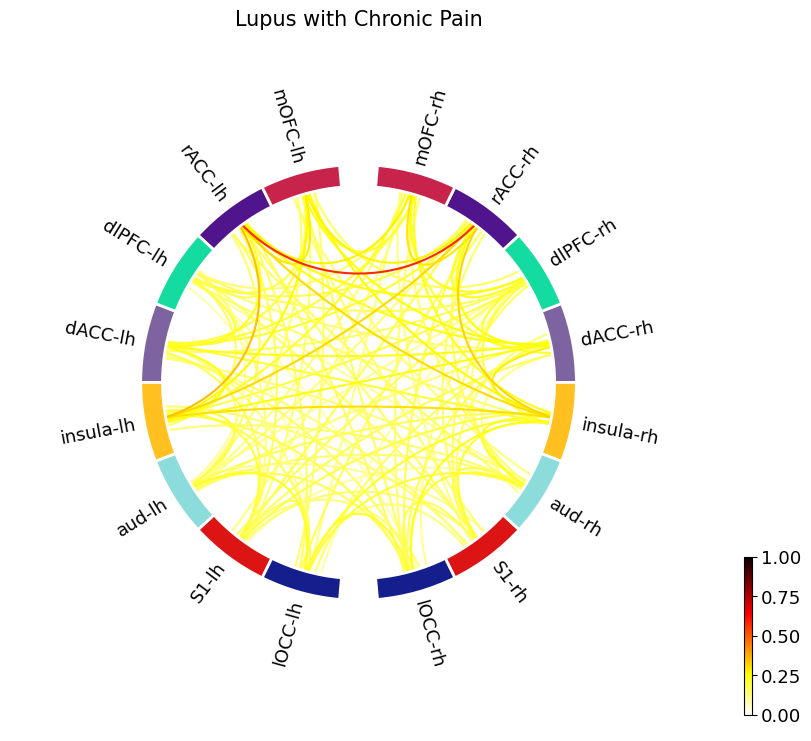

<Figure size 640x480 with 0 Axes>

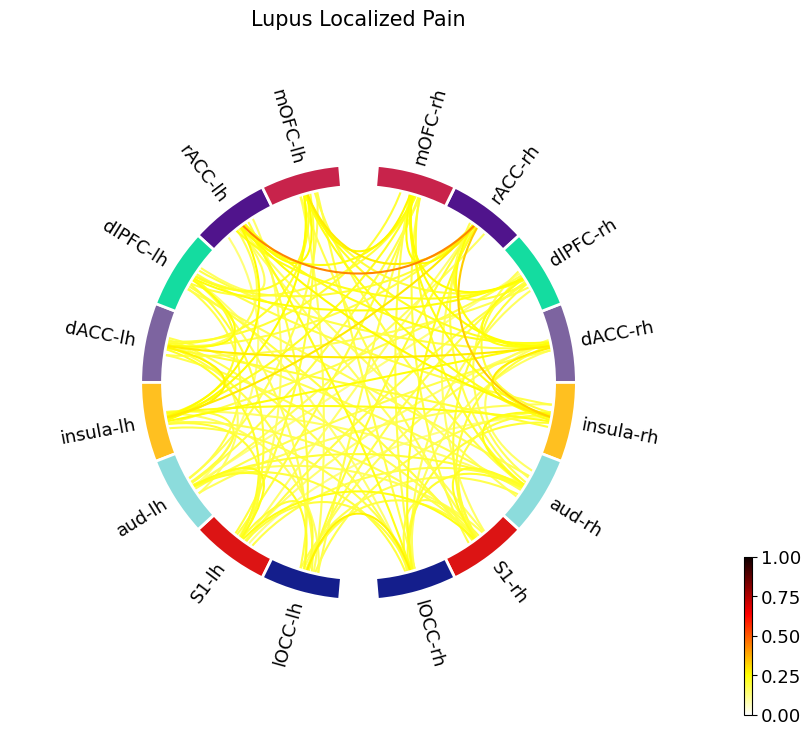

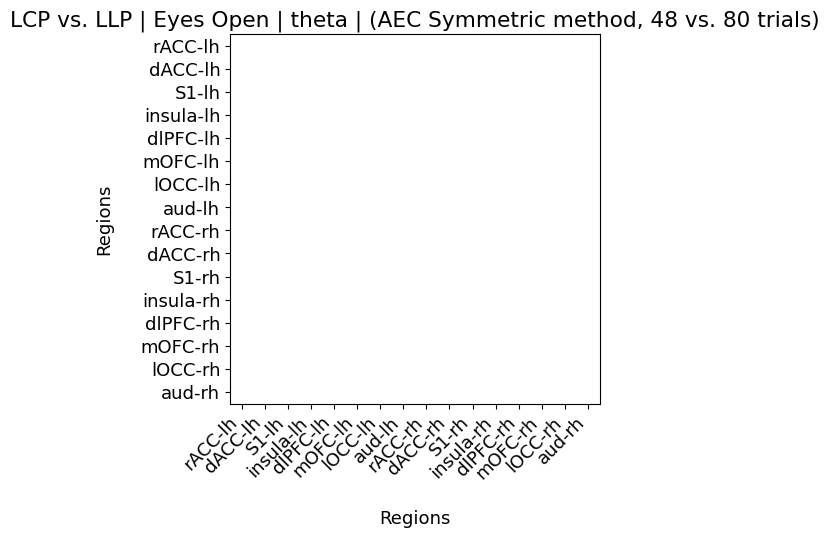

Eyes Open - Lupus with Chronic Pain vs. Lupus Localized Pain - aec_symmetric - alpha
Top 3 Connections in Lupus with Chronic Pain group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
| rACC-rh <-> rACC-lh |    3/3    |     0.469     |
| lOCC-rh <-> lOCC-lh |    1/3    |     0.362     |
| aud-rh <-> lOCC-rh  |    1/3    |     0.332     |
+---------------------+-----------+---------------+ 

Top 3 Connections in Lupus Localized Pain group
+-------------------------+-----------+---------------+
|       Connection        | Frequency | Mean Strength |
+-------------------------+-----------+---------------+
|   rACC-rh <-> rACC-lh   |    3/5    |     0.482     |
| insula-rh <-> insula-lh |    2/5    |     0.47      |
|   aud-rh <-> lOCC-rh    |    2/5    |     0.342     |
+-------------------------+-----------+---------------+ 

(3, 16, 16)

Betweenness Centrality by Region:
+-----+--

<Figure size 640x480 with 0 Axes>

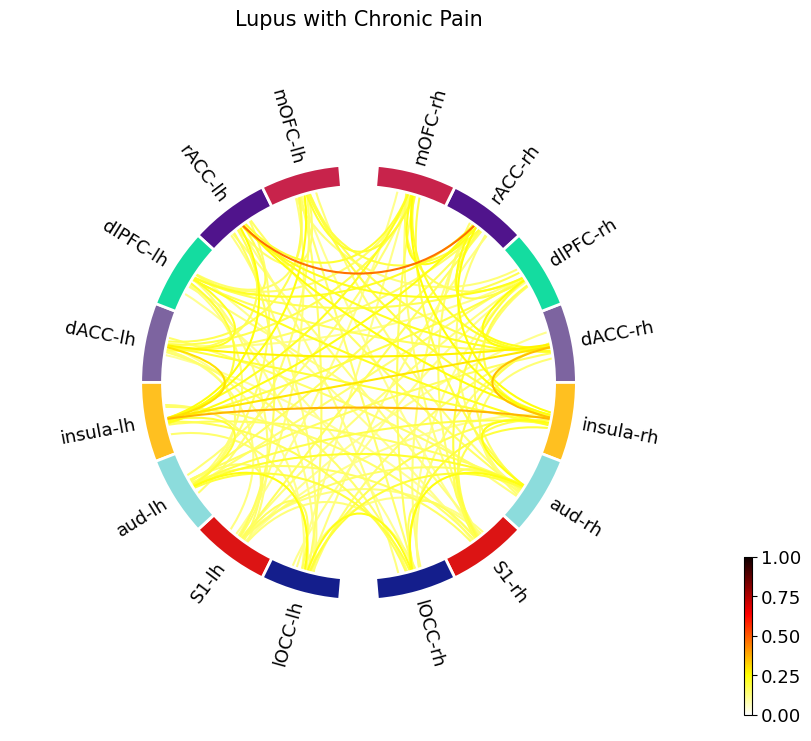

<Figure size 640x480 with 0 Axes>

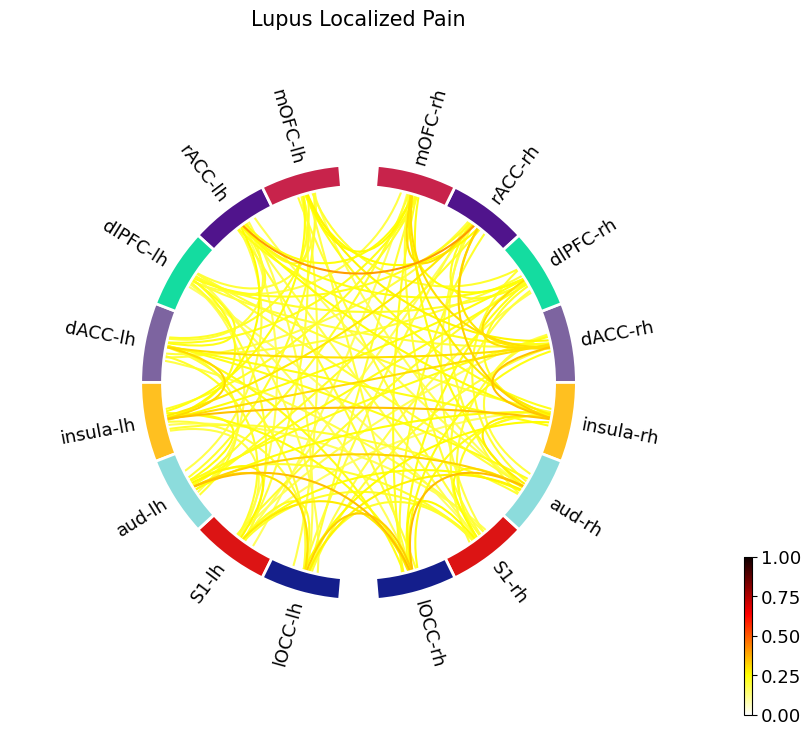

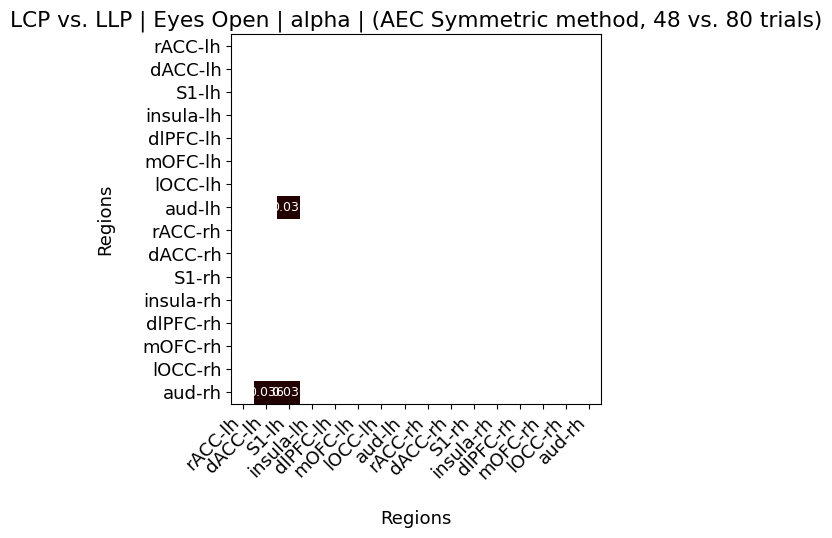

Eyes Open - Lupus with Chronic Pain vs. Lupus Localized Pain - aec_symmetric - beta
Top 3 Connections in Lupus with Chronic Pain group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
| aud-lh <-> lOCC-lh  |    2/3    |     0.398     |
| rACC-rh <-> rACC-lh |    2/3    |     0.452     |
| lOCC-rh <-> lOCC-lh |    1/3    |     0.541     |
+---------------------+-----------+---------------+ 

Top 3 Connections in Lupus Localized Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |    3/5    |     0.507     |
| insula-rh <-> rACC-rh |    2/5    |     0.347     |
|  lOCC-rh <-> lOCC-lh  |    2/5    |     0.446     |
+-----------------------+-----------+---------------+ 

(3, 16, 16)

Betweenness Centrality by Region:
+-----+---------+-------

<Figure size 640x480 with 0 Axes>

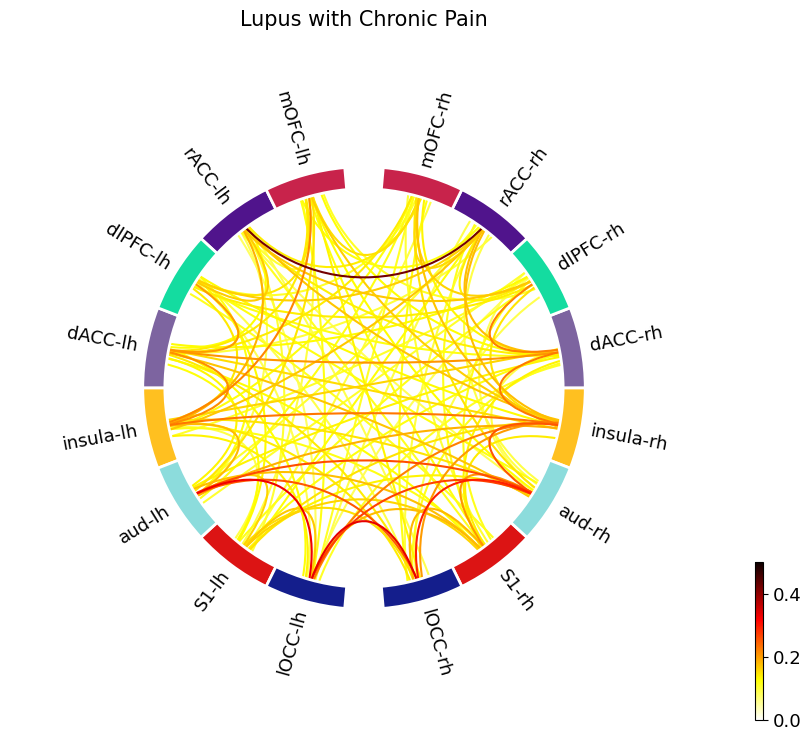

<Figure size 640x480 with 0 Axes>

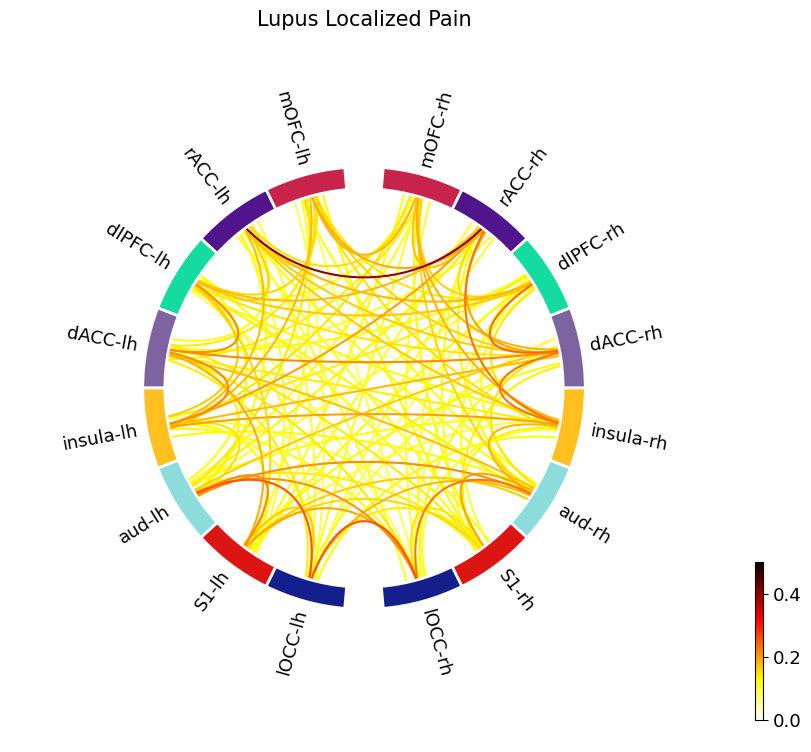

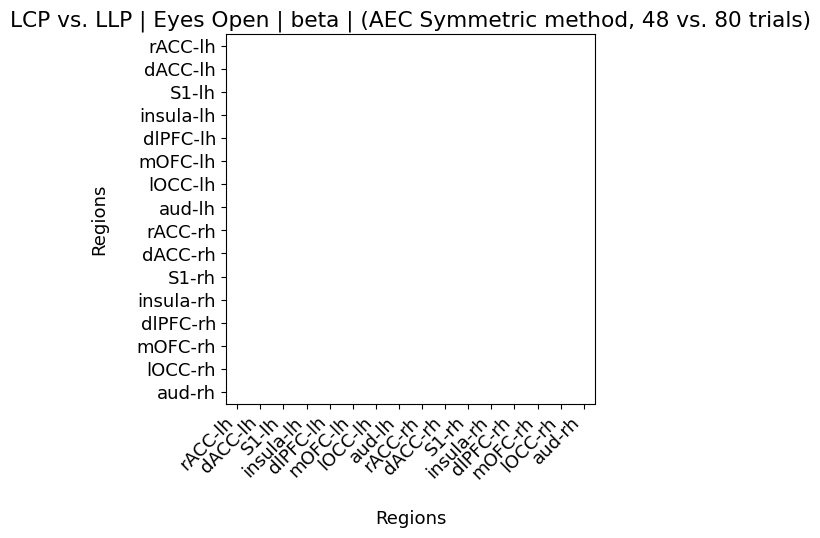

Eyes Open - Lupus with Chronic Pain vs. Lupus Localized Pain - aec_symmetric - low-gamma
Top 3 Connections in Lupus with Chronic Pain group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| rACC-rh <-> rACC-lh  |    3/3    |     0.463     |
| dlPFC-rh <-> dACC-rh |    1/3    |     0.311     |
|  aud-lh <-> lOCC-lh  |    1/3    |     0.306     |
+----------------------+-----------+---------------+ 

Top 3 Connections in Lupus Localized Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |    3/5    |     0.558     |
| mOFC-lh <-> insula-lh |    2/5    |     0.35      |
| insula-rh <-> rACC-rh |    2/5    |     0.306     |
+-----------------------+-----------+---------------+ 

(3, 16, 16)

Betweenness Centrality by Region:
+-----+-----

<Figure size 640x480 with 0 Axes>

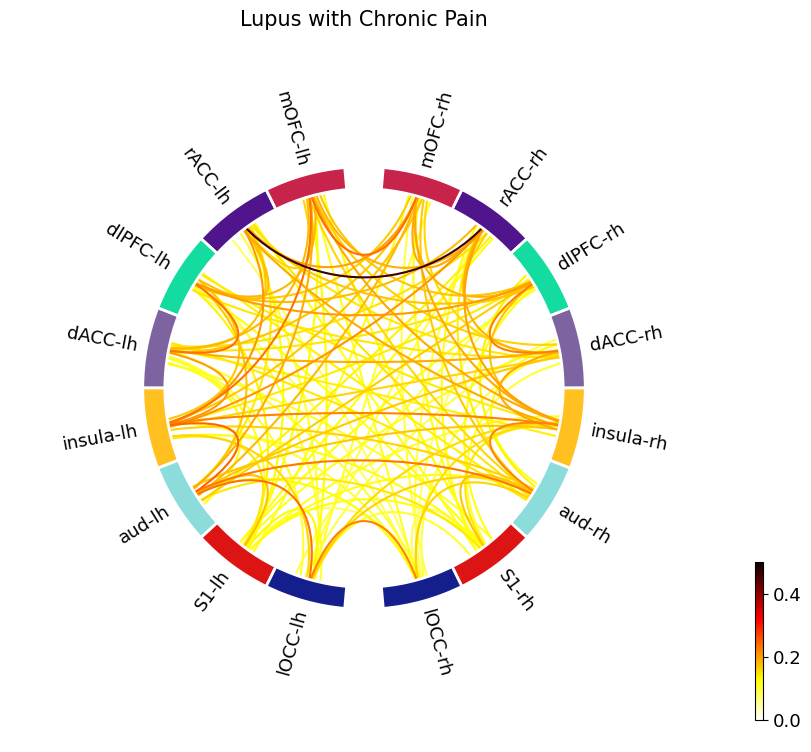

<Figure size 640x480 with 0 Axes>

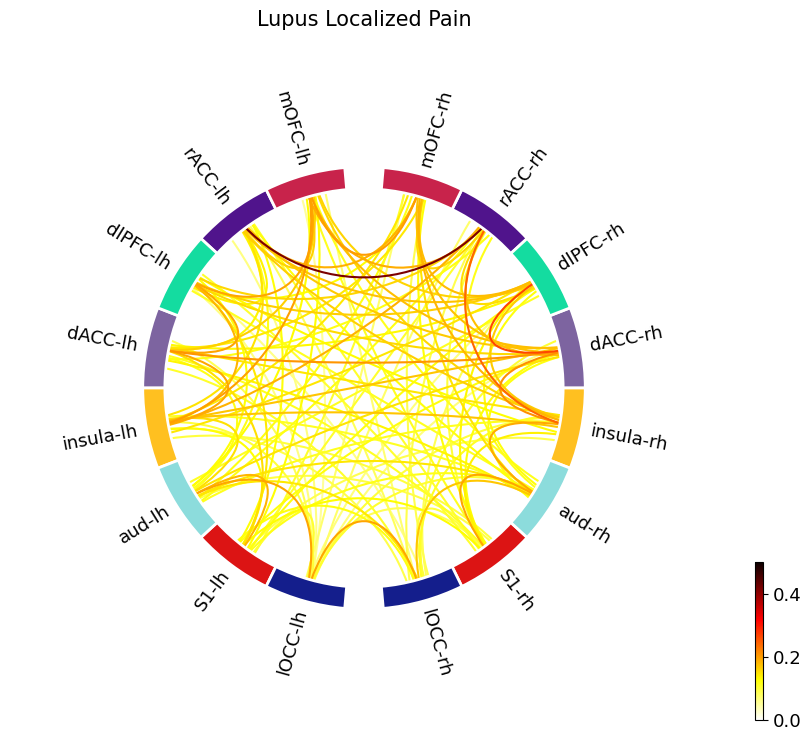

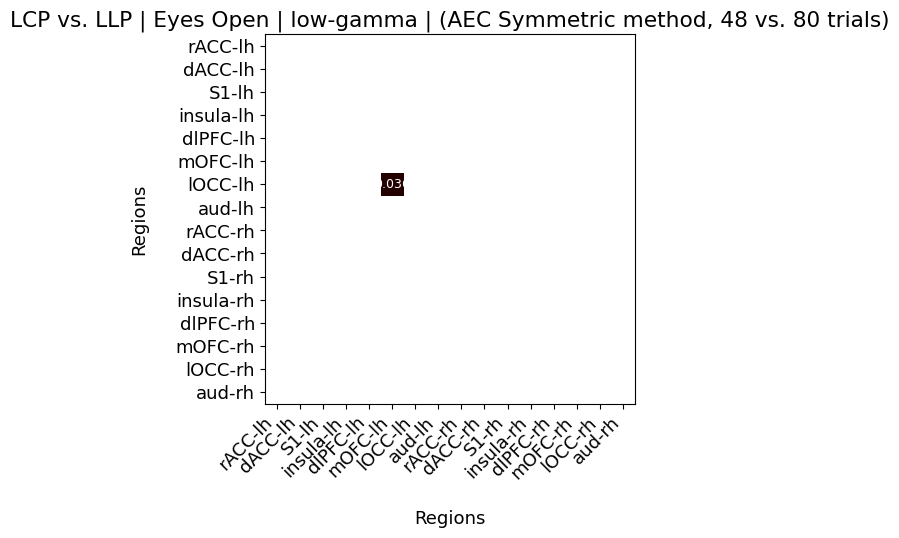

Eyes Open - Lupus with Chronic Pain vs. Lupus Localized Pain - aec_symmetric - high-gamma
Top 3 Connections in Lupus with Chronic Pain group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| rACC-rh <-> rACC-lh  |    3/3    |     0.57      |
| dlPFC-rh <-> dACC-rh |    1/3    |     0.435     |
|  aud-lh <-> lOCC-lh  |    1/3    |     0.378     |
+----------------------+-----------+---------------+ 

Top 3 Connections in Lupus Localized Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |    3/5    |     0.595     |
| dlPFC-rh <-> dACC-rh  |    3/5    |     0.392     |
| insula-rh <-> rACC-rh |    2/5    |     0.336     |
+-----------------------+-----------+---------------+ 

(3, 16, 16)

Betweenness Centrality by Region:
+-----+----

<Figure size 640x480 with 0 Axes>

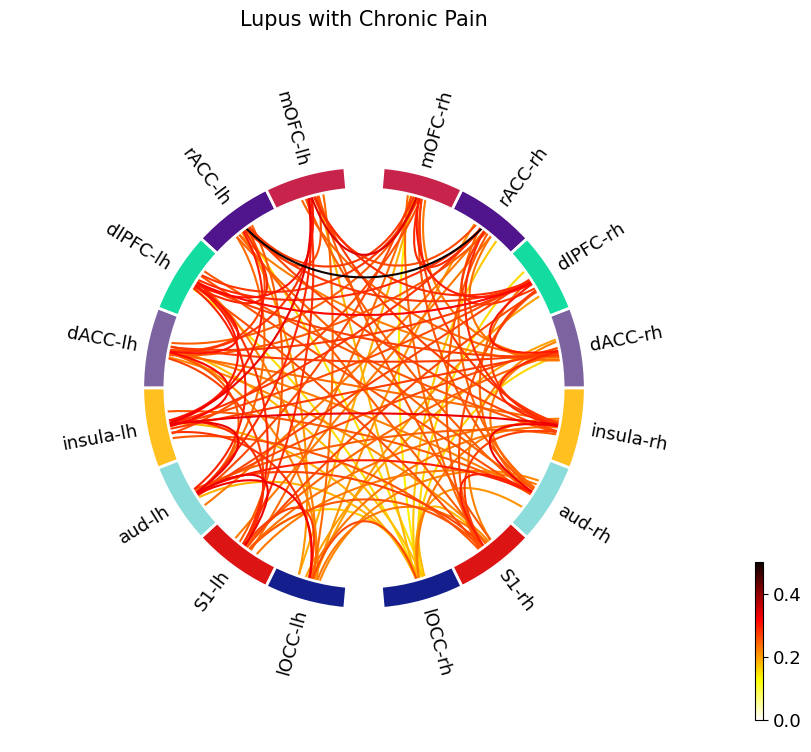

<Figure size 640x480 with 0 Axes>

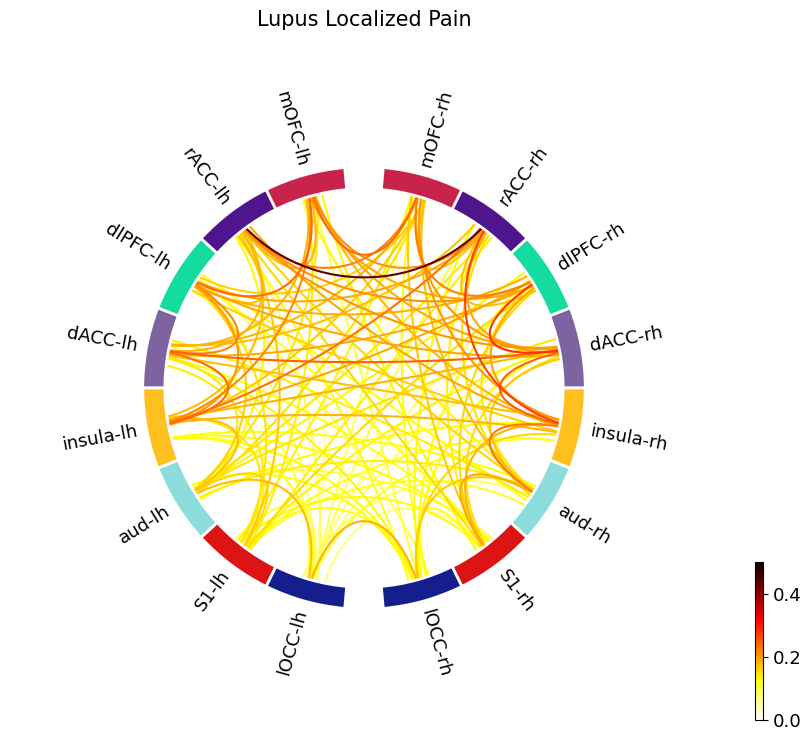

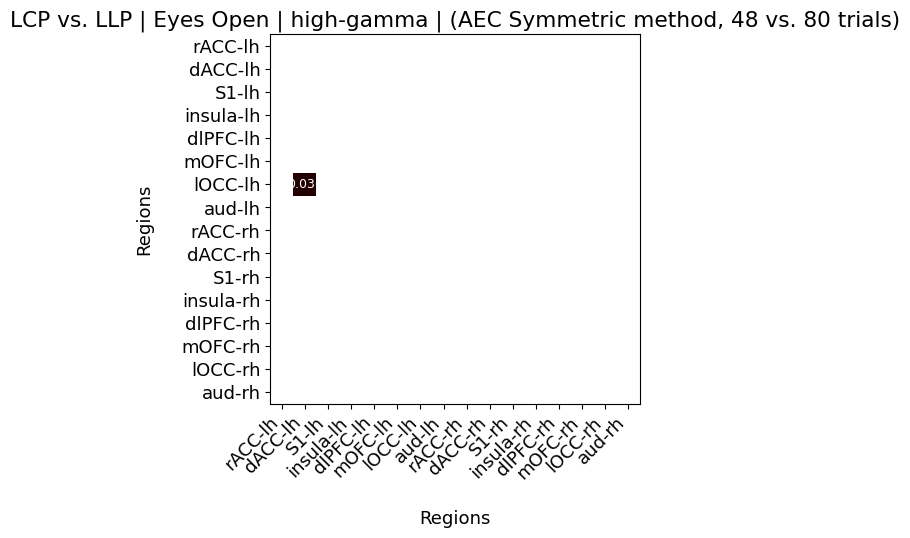

In [14]:
# Widespread Pain vs Localized Pain
these_group_names = ["Lupus with Chronic Pain", "Lupus Localized Pain", "Mann_Whitney_U_test"]
these_group_cons = [group_con_LCP, group_con_LLP]
these_sub_cons = [sub_con_LCP, sub_con_LLP]
these_sub_ids = [sub_ids_LCP, sub_ids_LLP]

for condition in conditions:
    # Make a directory for the stats
    stats_save_path = save_path / f"LCP_vs_LLP_{condition}"
    os.makedirs(stats_save_path, exist_ok=True)

    for method in con_methods:
        # Ignore some specific condition/method combinations
        if condition=="Hand 256 mN" and "aec" in method:
            continue
        elif condition=="Eyes Open" and method=="wpli2_debiased":
            continue

        for band in band_names:
            ## Save all output to a text file
            # Backup original stdout  
            orig_stdout = sys.stdout  
            if method=="wpli2_debiased":
                f = open(stats_save_path / f'{condition}_{band}_dwPLI.txt', 'w')  
            else:
                f = open(stats_save_path / f'{condition}_{band}_{method}.txt', 'w')
                
            # Set stdout to the file object  
            if save_txt:
                sys.stdout = f  
            
            # Select groups for mann-whitney
            print(f"{condition} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")
        
            # For each of the top 3 connections, add the connection, its frequency, and its mean strength to a list  
            top_3_info=None
            group_con=None
            for group_con,group_name,sub_con in zip(these_group_cons, these_group_names, these_sub_cons):
                table_data = []  
                top_3_info = group_con[condition][method][band]["top 3"] 
                print(f"Top 3 Connections in {group_name} group")
                for i in range(3):  
                    connection = top_3_info["connections"][i]  
                    frequency = top_3_info["frequency"][i]  
                    mean_strength = top_3_info["mean strength"][i]
                    table_data.append([f"{roi_acronyms[connection[0]]} <-> {roi_acronyms[connection[1]]}", f"{frequency}/{len(sub_con)}", mean_strength]) 
                
                # Define table headers  
                headers = ['Connection', 'Frequency', 'Mean Strength']  
                
                # Print the table  
                print(tabulate(table_data, headers, tablefmt='pretty'),'\n')  

            group1_stack = these_group_cons[0][condition][method][band]["data"]
            print(group1_stack.shape)
            group2_stack = these_group_cons[1][condition][method][band]["data"]

            nepochs_1 = these_group_cons[0][condition]['num_epochs']
            nepochs_2 = these_group_cons[1][condition]['num_epochs']
            
            # Compute the Mann-Whitney U test
            p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
                group1_stack,
                group2_stack,
                roi_acronyms=roi_acronyms,
                sub_ids1=these_sub_ids[0],
                sub_ids2=these_sub_ids[1],
                condition=condition,
                bilateral_pain_ids=None,
                round_neg_vals=round_neg_vals,
                method=method)

            # Need to custom set this because the colors blow out
            if 'Eyes' in condition and band in ["theta","alpha"]:
                vmin = 0.0
                vmax = 1.0
            elif 'Eyes' in condition and band not in ["theta","alpha"]:
                vmin = 0.0
                vmax = 0.5
            else:
                vmin = None
                vmax = None
            
            # Plotting
            # Gather the information for plotting
            plot_kwargs= dict(
                method=method,
                band=band, 
                roi_names=roi_names,
                roi_acronyms=roi_acronyms,
                condition=condition,
                vmin=vmin,
                vmax=vmax,
                group_names=these_group_names,
                nepochs=[nepochs_1, nepochs_2],
                titles=[these_group_names[0], 
                        these_group_names[1],
                        "LCP vs. LLP",],
                save_names=["Mann_Whitney_U_test",
                            these_group_names[0], 
                            these_group_names[1],
                            ],
                save_path=stats_save_path,
                )
            
            # Compute the centrality and test
            fc.compute_centrality_and_test(group1_stack,
                                            group2_stack, 
                                            roi_acronyms=roi_acronyms,
                                            sub_ids1=these_sub_ids[0],
                                            sub_ids2=these_sub_ids[1],
                                            bilateral_pain_ids=None,
                                            condition=condition,
                                            )
            
            print(f"\nNum epochs: {nepochs_1} vs. {nepochs_2}")               
            fc.plot_connectivity_and_stats(means_1=means_1,
                                        means_2=means_2,
                                        sem_1=sem_1,
                                        sem_2=sem_2,
                                        p_values=p_values,
                                        **plot_kwargs,
                                        save_fig=True,
                                        highlight_pvals=highlight_pvals,
                                        min_fc_val=None,
                                        set_title=set_title,
                                        show_fc_vals=show_fc_vals,
                                        round_neg_vals=round_neg_vals,
            )
        
            # Reset the standard output to its original value  
            sys.stdout = orig_stdout  
            
            f.close()  
        
            if "aec" in method and plot_brain:
                    # Convert ROI names to labels
                    labels = [
                        mne.read_labels_from_annot(
                            subject, regexp=roi, subjects_dir=subjects_dir
                        )[0]
                        for roi in roi_names
                    ]

                    # Load the inverse
                    inv = None
                    if "Eyes" not in condition:
                        inv = utils.unpickle_data(
                            zscored_epochs_data_path, f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Open":
                        inv = utils.unpickle_data(
                            EO_resting_data_path, f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Closed":
                        inv = utils.unpickle_data(
                            EC_resting_data_path, f"{sub_id}_inv.pkl"
                        )

                    fc.plot_degree(
                        p_values, 
                        title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_1, 
                        title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_2, 
                        title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )
            